In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.misc import imshow
import sys
sys.path.insert(0, '../../LEARNING/PCA_dl/')
from Dataset import DatasetNoLabel

In [2]:
data = pd.read_csv('./inputs/train.csv').values[:, 1:].reshape(-1, 28, 28, 1)

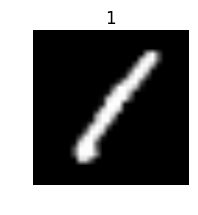

In [3]:
def showimg(imgdata, title=None, figsize=(2, 2), shape=(28, 28)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(imgdata.reshape(shape))
    plt.gray()
    plt.axis('off')
    if title != None:
        plt.title(title)

# test
showimg(data[0], 1)

In [68]:
def weight_variable(shape, name=None):
    return tf.Variable(tf.truncated_normal(shape = shape, stddev = 0.1), name)

def bias_variable(shape, name=None):
    return tf.Variable(tf.constant(0.1, shape = shape), name)

def conv2d(x, W, b, padding='SAME', activation='relu'):
    conv = tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding=padding)
    if activation == 'relu':
        return tf.nn.relu(conv+b)
    if activation == 'sigmoid':
        return tf.nn.sigmoid(conv+b)
    if activation == 'tanh':
        return tf.nn.tanh(conv+b)
    
def deconv2d(x, W, output_shape, activation='relu'):
    if activation == None:
        return tf.nn.conv2d_transpose(
                                      x, 
                                      W, 
                                      output_shape, 
                                      strides = [1, 2, 2, 1], 
                                      padding = 'SAME'
                                     )
    if activation == 'relu':
        return tf.nn.relu(tf.nn.conv2d_transpose(
                                                 x, 
                                                 W, 
                                                 output_shape, 
                                                 strides = [1, 2, 2, 1], 
                                                 padding = 'SAME'
                                                ))

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [69]:
def encoder(origin):
    layer = origin
    
    eW1 = weight_variable([5, 5, 1, 2], name='eW1')
    eb1 = bias_variable([2], name='eb1')
    el1 = conv2d(layer, eW1, eb1)
    print(el1.get_shape())
    
    eW2 = weight_variable([5, 5, 2, 4], name='eW2')
    eb2 = bias_variable([4], name='eb2')
    el2 = conv2d(el1, eW2, eb2)
    print(el2.get_shape())
    
    eW3 = weight_variable([5, 5, 4, 8], name='eW3')
    eb3 = bias_variable([8], name='eb3')
    el3 = conv2d(el2, eW3, eb3)
    print(el3.get_shape())     
    
    encoded = tf.reshape(el3, shape=[-1, 4*4*8])
    #encoded = el3
    return encoded

def decoder(encoded):
    layer = tf.reshape(encoded, shape=[-1, 4, 4, 8])
    
    outshape_d1 = tf.pack([tf.shape(layer)[0], 7, 7, 4])
    dW1 = weight_variable([5, 5, 4, 8], name='dW1')
    dl1 = deconv2d(layer, dW1, outshape_d1)
    
    outshape_d2 = tf.pack([tf.shape(layer)[0], 14, 14, 2])
    dW2 = weight_variable([5, 5, 2, 4], name='dW2')
    dl2 = deconv2d(dl1, dW2, outshape_d2)
    
    outshape_d3 = tf.pack([tf.shape(layer)[0], 28, 28, 1])
    dW3 = weight_variable([5, 5, 1, 2], name='dW3')
    dl3 = deconv2d(dl2, dW3, outshape_d3, activation=None)
    
    decoded = dl3
    return decoded

In [70]:
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))


ED = encoder(x)
DD = decoder(ED)

(?, 14, 14, 2)
(?, 7, 7, 4)
(?, 4, 4, 8)


In [72]:
loss = tf.reduce_mean(tf.pow(DD - x, 2))
optimizer = tf.train.RMSPropOptimizer(0.001).minimize(loss)

dataset = DatasetNoLabel(data)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for _ in xrange(10000):
        batch = dataset.next_batch(64)
        feed_dict = {x: batch}
        sess.run(optimizer, feed_dict=feed_dict)
        if (_+1)%100 == 0:
            print("step:{} loss: {}".format(_+1, sess.run(loss, feed_dict={x: data})))
    
    decoded_img = sess.run(DD, feed_dict={x: data})

step:100 loss: 3666.28076172
step:200 loss: 2745.70776367
step:300 loss: 2135.26464844
step:400 loss: 1855.56762695
step:500 loss: 1712.7109375
step:600 loss: 1667.28674316
step:700 loss: 1635.90820312
step:800 loss: 1648.99902344
step:900 loss: 1517.2911377
step:1000 loss: 1383.10656738
step:1100 loss: 1366.41174316
step:1200 loss: 1367.13964844
step:1300 loss: 1268.18786621
step:1400 loss: 1239.95275879
step:1500 loss: 1175.53210449
step:1600 loss: 1164.4128418
step:1700 loss: 1133.97839355
step:1800 loss: 1185.16760254
step:1900 loss: 1073.89929199
step:2000 loss: 1192.73510742
step:2100 loss: 1106.7779541
step:2200 loss: 1032.47705078
step:2300 loss: 1001.87200928
step:2400 loss: 1018.06561279
step:2500 loss: 973.848266602
step:2600 loss: 1022.04199219
step:2700 loss: 1042.61938477
step:2800 loss: 935.410888672
step:2900 loss: 933.436340332
step:3000 loss: 906.454284668
step:3100 loss: 1043.36633301
step:3200 loss: 896.008850098
step:3300 loss: 910.710205078
step:3400 loss: 957.770

In [73]:
restructed = decoded_img.reshape(-1, 28, 28)

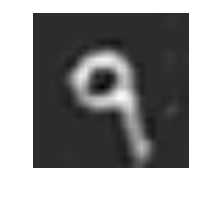

In [86]:
k = np.random.randint(data.shape[0])
showimg(restructed[k])

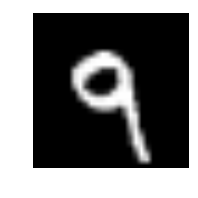

In [87]:
showimg(data[k])

In [42]:
ED.get_shape()

TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(8)])